In [20]:
import os
import json
from itertools import groupby
from torch.optim import Adam
from torch.nn import functional as nnf
from torchvision.transforms import functional as transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch
from torch import nn

import matplotlib.pyplot as plt

import numpy as np
from os.path import join, isdir, expanduser
from PIL import Image
from datetime import datetime
from time import time, sleep


data_path = expanduser('~/datasets')

exp_id = "05"

In [24]:
# num_images = 1000
# size = (256,256)

# trainA_path = ["share", "Florian_Jonas_construction"]
# trainB_path = ["share", "Florian_Jonas_finished"]

# train_A_files = os.listdir(join(data_path, *trainA_path))
# train_B_files = os.listdir(join(data_path, *trainB_path))


# train_A_raw = [Image.open(join(data_path, *trainA_path, f)).resize(size)
#           for f in tqdm(train_A_files[30:num_images], desc="A loading") if f.endswith('.jpg')]

# train_B_raw = [Image.open(join(data_path, *trainB_path, f)).resize(size)
#           for f in tqdm(train_B_files[30:num_images], desc="B loading") if f.endswith('.jpg')]


# trans = ToTensor()

# train_A = [trans(img) for img in tqdm(train_A_raw, desc="A processing") if trans(img).shape == (3, 256, 256)]
# train_B = [trans(img) for img in tqdm(train_B_raw, desc="B processing") if trans(img).shape == (3, 256, 256)]

# torch.save(train_A, "A.pt")
# torch.save(train_B, "B.pt")

B processing: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]


In [3]:
batch_size = 32

train_A = torch.load("A.pt")
train_B = torch.load("B.pt")

A_loader = torch.utils.data.DataLoader(train_A, batch_size=batch_size, shuffle=True, drop_last=True)
B_loader = torch.utils.data.DataLoader(train_B, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        conv1 = nn.Conv2d(channels, channels, 3)
        bn1 = nn.BatchNorm2d(channels)
        relu = nn.ReLU()
        conv2 = nn.Conv2d(channels, channels, 3)
        bn2 = nn.BatchNorm2d(channels)
        
        self.Layers = nn.Sequential(conv1, bn1, relu, conv2, bn2)
        
    def forward(self, x):
        x_crop = x[:,:,2:-2,2:-2]
        return self.Layers(x) + x_crop
    

resblock = ResBlock(128).cuda()

dummydata = torch.randn([batch_size,128,84,84]).cuda()

print(resblock(dummydata).shape)
del resblock
del dummydata

torch.Size([32, 128, 80, 80])


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.padder =  nn.ReflectionPad2d(40)
        self.conv1 = nn.Conv2d(3, 32, 9, padding="same")
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        
        self.resblocks = nn.Sequential(*[ResBlock(128) for _ in range(5)])
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size= 2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size= 2, stride=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size= 9, stride=1, padding="same")
    
    def forward(self, x):
        for layer in [self.padder, self.conv1, self.conv2, self.conv3]:
            x = layer(x)
            
        x =  self.resblocks(x)
        
        x = nn.Tanh()(self.conv4(self.upconv2(self.upconv1(x))))
        
        return x
    
gen = Generator()
dummydata = torch.randn([batch_size,3,128,128])
print(gen(dummydata).shape)


del gen
del dummydata

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, d=64):
        super().__init__()
        
        self.lrelu = nn.LeakyReLU(0.2)
        
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
       
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(d * 8,1)
        self.sig = nn.Sigmoid()
        
        
        

    def forward(self, x):
        
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2_bn(self.conv2(x)))
        x = self.lrelu(self.conv3_bn(self.conv3(x)))
        x = self.lrelu(self.conv4_bn(self.conv4(x)))
        
        x = self.sig((self.linear(self.flatten(self.pool(x)))))

        return x

        
dis = Discriminator(64).cuda()
dummydata = torch.randn([batch_size,3,128,128]).cuda()
print(dis(dummydata).shape)


del dis
del dummydata

torch.Size([32, 1])


In [11]:
from torchvision.transforms import Resize, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize, Compose, InterpolationMode

transform_pipeline = Compose([
    RandomCrop(200),
    RandomHorizontalFlip(p=0.5),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Resize(128, InterpolationMode.BICUBIC)
])

def unprocess(img):
    img = img.permute(1,2,0)
    img = img - img.min()
    return img / img.max()

def show(images):
    l = len(images)
   
    _, axs = plt.subplots(1, l, figsize=(15,7))
    for i, img in enumerate(images):
        axs[i].imshow(unprocess(img))
        axs[i].axis('off')
    plt.show()

test = next(iter(A_loader))
    
res = transform_pipeline(test)

In [21]:
G_ab = Generator().cuda()
G_ba = Generator().cuda()

D_a = Discriminator(d=128).cuda()
D_b = Discriminator(d=128).cuda()

opt_G = Adam(list(G_ab.parameters()) + list(G_ba.parameters()), lr=0.0002, betas=(0.5, 0.999))
opt_D_a = Adam(D_a.parameters(), lr=0.0001, betas=(0.5, 0.999))
opt_D_b = Adam(D_b.parameters(), lr=0.0001, betas=(0.5, 0.999))
losses = [[], [], []]

In [22]:
def saver(G_ab, G_ba, D_a, D_b, exp_id = ""):
    now = datetime.now()
    time = now.strftime("%m.%d._%H:%M")
    
    path = os.path.join("saves", exp_id, time)
    
    os.makedirs(path)
    
    names = ["G_ab", "G_ba", "D_a", "D_b"]
    models = [G_ab, G_ba, D_a, D_b]
    
    for name, model in zip(names, models):
        torch.save(model.state_dict(), os.path.join(path, name + ".pt"))
        


In [23]:
epochs = 999

last_save = time()

for i in range(epochs):
    
    if time() - last_save >= 1800:
        last_save = time()
        saver(G_ab, G_ba, D_a, D_b, exp_id)
    
    for a_batch, b_batch in zip(A_loader, B_loader):

        a_batch = transform_pipeline(a_batch).cuda().float()
        b_batch = transform_pipeline(b_batch).cuda().float()

        ones, zeros = torch.ones(batch_size,1).cuda(), torch.zeros(batch_size,1).cuda()
        # train generators

        opt_G.zero_grad()

        G_ab.train()
        G_ba.train()

        # if input is from right distribution (or class) already: don't change it
        loss_eye = (nnf.l1_loss(G_ba(a_batch), a_batch) + nnf.l1_loss(G_ab(b_batch), b_batch)) / 2

        # let's fool the discriminator a bit...
        fake_a, fake_b = G_ba(b_batch), G_ab(a_batch)
        loss_fool_d = (nnf.mse_loss(D_a(fake_a), ones) + nnf.mse_loss(D_b(fake_b), ones)) / 2

        # by applying the generators twice we should be back at the initial sample
        loss_cycle = (nnf.l1_loss(G_ba(fake_b), a_batch) + nnf.l1_loss(G_ab(fake_a), b_batch)) / 2

        loss_g = 5 * loss_eye  + loss_cycle * 10 + loss_fool_d
        loss_g.backward()
        opt_G.step()

        # train discriminator A
        opt_D_a.zero_grad()
        loss_d_a = 0.5 * nnf.mse_loss(D_a(a_batch), ones)
        loss_d_a += 0.5 * nnf.mse_loss(D_a(fake_a.detach()), zeros)
        loss_d_a.backward()
        opt_D_a.step()

        # train discriminator B
        opt_D_b.zero_grad()
        loss_d_b = 0.5 * nnf.mse_loss(D_b(b_batch), ones)
        loss_d_b += 0.5 * nnf.mse_loss(D_b(fake_b.detach()), zeros)
        loss_d_b.backward()
        opt_D_b.step()

        losses[0] += [float(loss_g)]
        losses[1] += [float(loss_d_a)]
        losses[2] += [float(loss_d_b)]
        
        del a_batch
        del b_batch
        torch.cuda.empty_cache()        
        

    print(f'generator: {np.mean(losses[0]):.5f}, D_a: {np.mean(losses[1]):.5f}, D_b: {np.mean(losses[2]):.5f}')


generator: 4.80243, D_a: 0.26046, D_b: 0.25941
generator: 4.07560, D_a: 0.24185, D_b: 0.24683
generator: 3.82262, D_a: 0.23476, D_b: 0.23942
generator: 3.62248, D_a: 0.22820, D_b: 0.23081
generator: 3.47678, D_a: 0.21994, D_b: 0.22447
generator: 3.36397, D_a: 0.21319, D_b: 0.21626
generator: 3.29326, D_a: 0.20804, D_b: 0.20967


KeyboardInterrupt: 

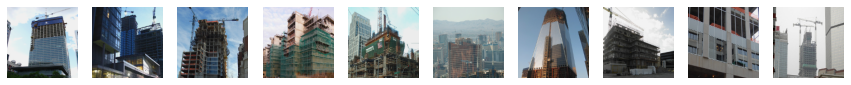

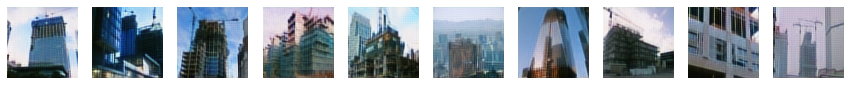

In [9]:
test_a = next(iter(A_loader))
test_a = transform_pipeline(test_a)

show(test_a[:10])

res = G_ab(test_a[:10].cuda()).cpu().detach()
show(res)

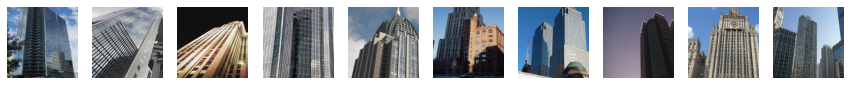

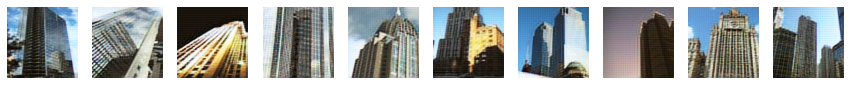

In [10]:
test_b = next(iter(B_loader))
test_b = transform_pipeline(test_b)

show(test_b[:10])

res = G_ba(test_b[:10].cuda()).cpu().detach()
show(res)